In [1]:
import matplotlib.pyplot as plt
import numpy as np
from fast_histogram import histogram2d
from matplotlib.pyplot import imshow
import matplotlib.patches as patches
from util import load_dicom, load_dicom_volume
from scipy import ndimage, misc
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
import itertools
import time
from tqdm import tqdm_notebook as tqdm, tnrange as trange
from scipy.stats import chi2_contingency

In [2]:
def interp3d(arr, newshape, kind='linear'):
    dim = 3
    pts = [np.linspace(0, 1, shape) for shape in arr.shape]
    fn = RegularGridInterpolator(pts, arr, method=kind)
    newpts = [np.linspace(0, 1, shape) for shape in newshape]
    return fn(list(itertools.product(*newpts))).reshape(newshape)

In [3]:
def rescale(image, scale):
    return interp3d(image, np.multiply(image.shape, scale).astype(int))

In [4]:
def mutual_info_score(x, y, bins):
    c_xy = np.histogram2d(x, y, bins=bins)[0]
    g, p, dof, expected = chi2_contingency(c_xy, lambda_="log-likelihood")
    mi = 0.5 * g / c_xy.sum()
    return mi

In [5]:
def normalize(arr):
    return (arr - np.amin(arr)) / (np.amax(arr) - np.amin(arr))

In [6]:
def align(img1, img2, pos1, pos2):
    pad1 = [[0, 0], [0, 0]]
    pad2 = [[0, 0], [0, 0]]
    if pos1[0] < pos2[0]:
        pad1[0][0] = pos2[0] - pos1[0]
    else:
        pad2[0][0] = pos1[0] - pos2[0]
    if pos1[1] < pos2[1]:
        pad1[1][0] = pos2[1] - pos1[1]
    else:
        pad2[1][0] = pos1[1] - pos2[1]
    pad1[0][1] = max((img2.shape[0] + pad2[0][0]) - (img1.shape[0] + pad1[0][0]), 0)
    pad1[1][1] = max((img2.shape[1] + pad2[1][0]) - (img1.shape[1] + pad1[1][0]), 0)
    pad2[0][1] = max((img1.shape[0] + pad1[0][0]) - (img2.shape[0] + pad2[0][0]), 0)
    pad2[1][1] = max((img1.shape[1] + pad1[1][0]) - (img2.shape[1] + pad2[1][0]), 0)
    img1 = np.pad(img1, pad1, 'constant', constant_values=np.amin(img1))
    img2 = np.pad(img2, pad2, 'constant', constant_values=np.amin(img2))
    return img1, img2

In [7]:
# Case 1
ct_ori, ct_size = load_dicom_volume("/home/kevinptt/Documents/research/data/pointrobotics/Image_20180509/Case1/CT/S3010_TH1_Gap1/", pixel_size=True)
mr_ori, mr_size = load_dicom_volume("/home/kevinptt/Documents/research/data/pointrobotics/Image_20180509/Case1/MRI/S3010_T1/", pixel_size=True)
# T12
ct_index = slice(4, 34), slice(257, 357), slice(203, 309)
mr_index = None, None, slice(172, None)

# L5
#ct_index = slice(178, 221), slice(204, 299), slice(188, 317)
#mr_index = None, None, slice(638, None)


# Case 2
# ct_ori, ct_size = load_dicom_volume("/home/kevinptt/Documents/research/data/pointrobotics/Image_20180509/Case2/CT/S6220/S2020_TH1_Gap0.8/", pixel_size=True)
# mr_ori, mr_size = load_dicom_volume("/home/kevinptt/Documents/research/data/pointrobotics/Image_20180509/Case2/MRI/S53650/S3010_T1_Sagittal/", pixel_size=True)
# T12
# ct_index = slice(61, 104), slice(205, 326), slice(202, 317)
# mr_index = None, None, slice(25, None)


print(ct_ori.shape, ct_size)
print(mr_ori.shape, mr_size)

(341, 512, 512) [1.0, 0.4375, 0.4375]
(90, 1008, 1008) [1.0, 0.37313431501388, 0.37313431501388]


In [8]:
mr_ori_t = np.transpose(mr_ori, (1, 2, 0))

In [9]:
ct = rescale(ct_ori, ct_size)
mr = rescale(mr_ori, mr_size)
mr = np.transpose(np.flip(mr, 0), (1, 2, 0))
ct_newshape = np.multiply(ct_ori.shape, ct_size).astype(int)
mr_newshape = np.multiply(mr_ori.shape, mr_size).astype(int)
print(ct_newshape, ct.shape)
print(mr_newshape, mr.shape)

[341 224 224] (341, 224, 224)
[ 90 376 376] (376, 376, 90)


(30, 43, 46)


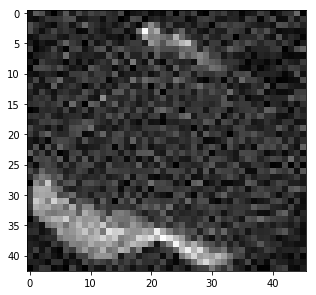

In [10]:
ct_spine1 = rescale(ct_ori[ct_index], ct_size)
print(ct_spine1.shape)
plt.figure(figsize = (5, 5))
imshow(ct_spine1[0], cmap=plt.cm.gray)

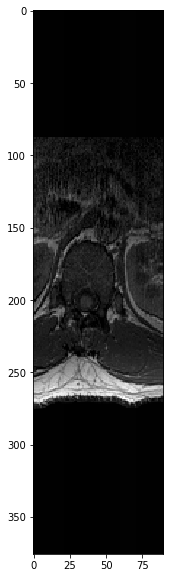

In [11]:
plt.figure(figsize = (10, 10))
imshow(mr[int(mr_index[2].start * mr_size[1]) + 15], cmap=plt.cm.gray)

In [12]:
mi_arr = np.zeros(np.subtract(mr.shape, ct_spine1.shape))
x = ct_spine1.reshape(-1)
eps = 1e-5
x_range = (x.min(), x.max()+eps)
guess_z = int(mr_index[2].start * mr_size[1])
print("guess_z: ", guess_z)
#for i in tqdm(range(mi_arr.shape[0])):
for i in trange(guess_z-2, guess_z+3):
    for j in trange(mi_arr.shape[1], leave=False):
        for k in range(mi_arr.shape[2]):
            y = mr[i:i+ct_spine1.shape[0],j:j+ct_spine1.shape[1],k:k+ct_spine1.shape[2]].reshape(-1)
            y_range = (y.min(), y.max()+eps)
            c_xy = histogram2d(x, y, range=(x_range, y_range), bins=64)
            #c_xy = np.histogram2d(x, y, bins=50)[0]
            mi_arr[i,j,k] = metrics.mutual_info_score(None, None, contingency=c_xy)
            #mi_arr[i,j,k] = metrics.mutual_info_score(ct_spine1_1, tmp_mr.reshape(-1))

guess_z:  64


In [13]:
pad_before = np.array(ct_spine1.shape) // 2
pad_after = np.subtract(ct_spine1.shape, pad_before)
mi_arr_pad = np.pad(mi_arr, list(zip(pad_before, pad_after)), 'edge')
print('pad_before: ', pad_before)
print('pad_after: ', pad_after)
# print("%s -> %s" % (mi_arr.shape, mi_arr_pad.shape))

pad_before:  [15 21 23]
pad_after:  [15 22 23]


In [14]:
max_mi = 0
max_mi_pos = pad_before
for i in trange(guess_z+pad_before[0]-2, guess_z+pad_before[0]+3):
    #for j in range(mi_arr_pad.shape[1]):
    for j in range(150, 200):
        for k in range(mi_arr_pad.shape[2]):
            if mi_arr_pad[i,j,k] > max_mi:
                max_mi = mi_arr_pad[i,j,k]
                max_mi_pos_pad = (i, j, k)
max_mi_pos = max_mi_pos_pad - pad_before
print('{} ({}) : {:f}'.format(max_mi_pos_pad, max_mi_pos, max_mi))
#print(mi_arr_pad[75,150:,30:])


(80, 178, 37) ([ 65 157  14]) : 0.119233


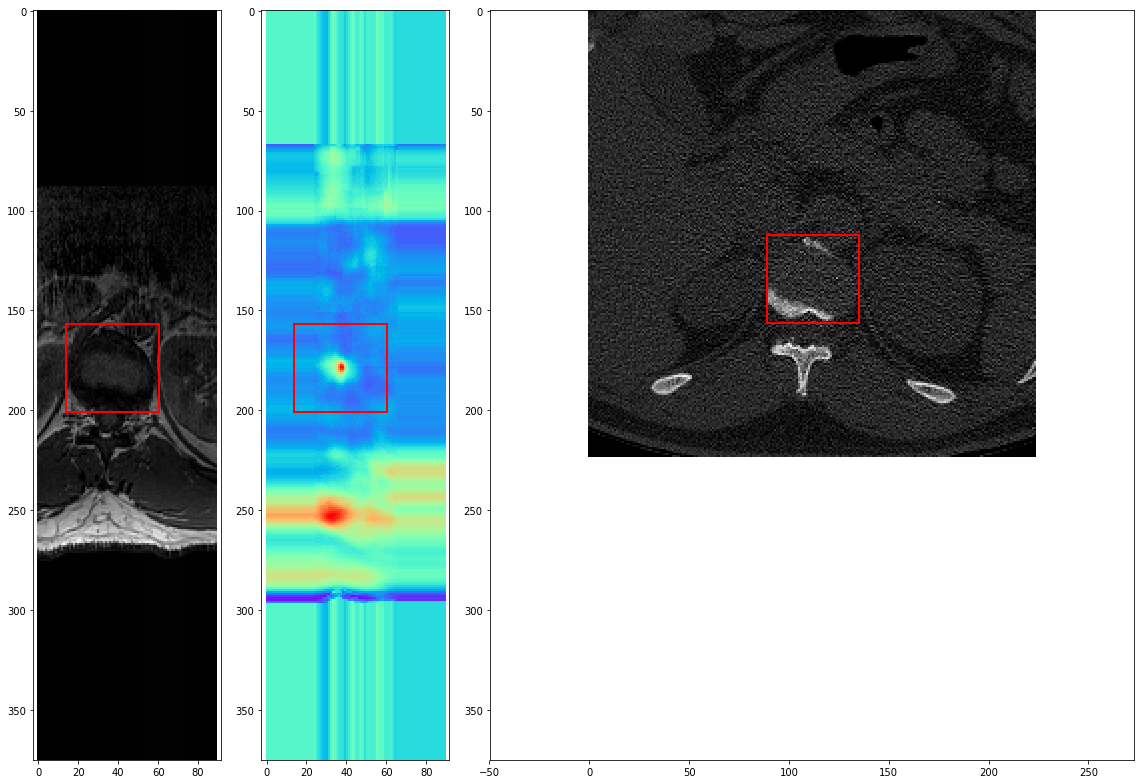

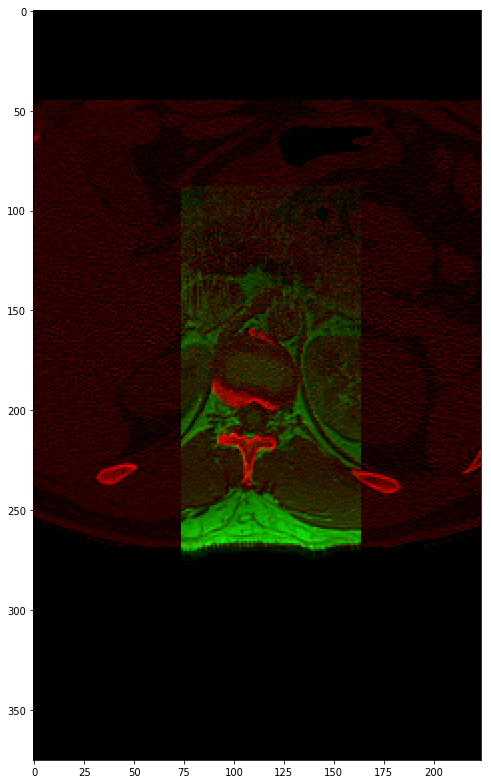

In [15]:
offset = 0
fig = plt.figure(1, figsize=(16, 11))
ax = [0, 0, 0]
ax[0] = plt.subplot2grid((1, 5), (0, 0))
ax[1] = plt.subplot2grid((1, 5), (0, 1), sharey=ax[0])
ax[2] = plt.subplot2grid((1, 5), (0, 2), colspan=3, sharey=ax[0])

height, width = ct_index[2].stop - ct_index[2].start, ct_index[1].stop - ct_index[1].start
height, width = height * ct_size[1], width * ct_size[2]

ax[0].imshow(mr[max_mi_pos[0] + offset], cmap=plt.cm.gray)
y, x = max_mi_pos[1], max_mi_pos[2]
rect = patches.Rectangle((x, y), height, width, linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)

ax[1].imshow(mi_arr_pad[max_mi_pos_pad[0]], cmap=plt.cm.rainbow)
rect = patches.Rectangle((x, y), height, width, linewidth=2, edgecolor='r', facecolor='none')
ax[1].add_patch(rect)

ax[2].imshow(ct[ct_index[0].start + offset], cmap=plt.cm.gray)
x, y = ct_index[2].start * ct_size[1], ct_index[1].start * ct_size[2]
rect = patches.Rectangle((x, y), height, width, linewidth=2, edgecolor='r', facecolor='none')
ax[2].add_patch(rect)

plt.ylim(ymin=mr.shape[1]-1)
fig.tight_layout()

fig = plt.figure(2, figsize=(16, 11))
img1, img2 = align(ct[ct_index[0].start + offset], mr[max_mi_pos[0] + offset],
            np.array([int(ct_index[1].start * ct_size[2]), int(ct_index[2].start * ct_size[1])]),
            np.array([max_mi_pos[1], max_mi_pos[2]]))

img = np.stack([normalize(img1), normalize(img2), np.zeros_like(img1)], axis=2)
plt.imshow(img)

plt.ylim(ymin=mr.shape[1]-1)
fig.tight_layout()

(376, 376, 90)
157 200
14 60


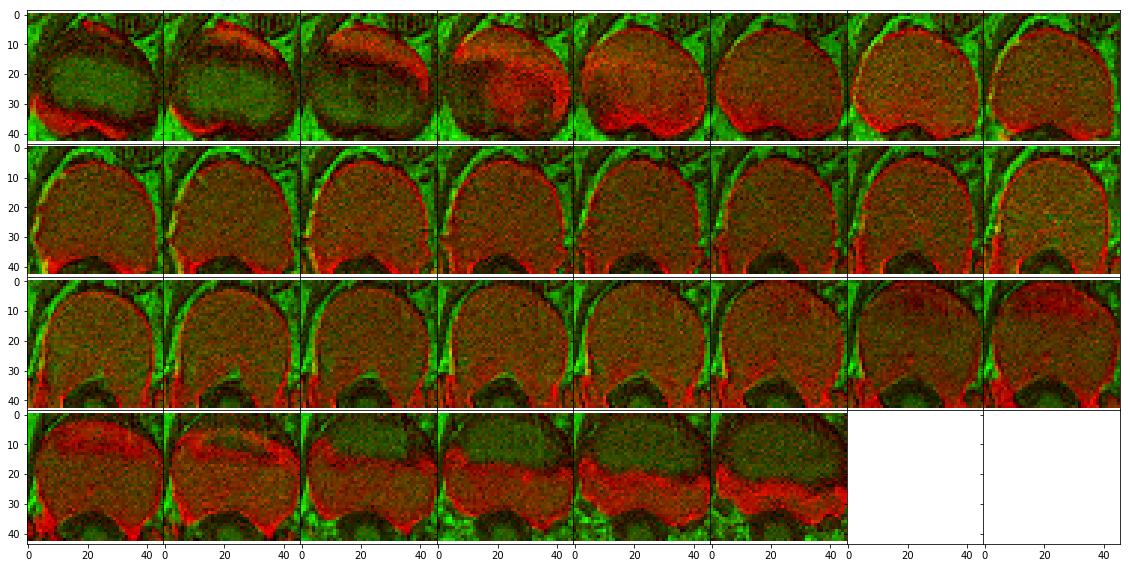

In [16]:
#fig, ax = plt.subplots(nrows=ct_spine1.shape[0], ncols=2, figsize=(8, 4*ct_spine1.shape[0]), sharex='col')
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(16, 8), sharex='col', sharey='row')
fig.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0)
print(mr.shape)
print(max_mi_pos[1], max_mi_pos[1]+ct_spine1.shape[1])
print(max_mi_pos[2], max_mi_pos[2]+ct_spine1.shape[2])
for t in range(ct_spine1.shape[0]):
    i, j = t // 8, t % 8
    ch1 = normalize(ct_spine1[i*8+j])
    ch2 = normalize(mr[max_mi_pos[0]+i*8+j,max_mi_pos[1]:max_mi_pos[1]+ct_spine1.shape[1],max_mi_pos[2]:max_mi_pos[2]+ct_spine1.shape[2]])
    img = np.stack([ch1, ch2, np.zeros_like(ch1)], axis=2)
    ax[i][j].imshow(img)
    #ax[i][j*2+1].imshow(Z, cmap=plt.get_cmap('bone'))

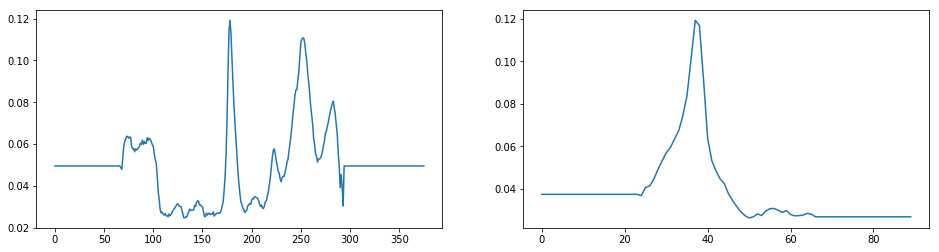

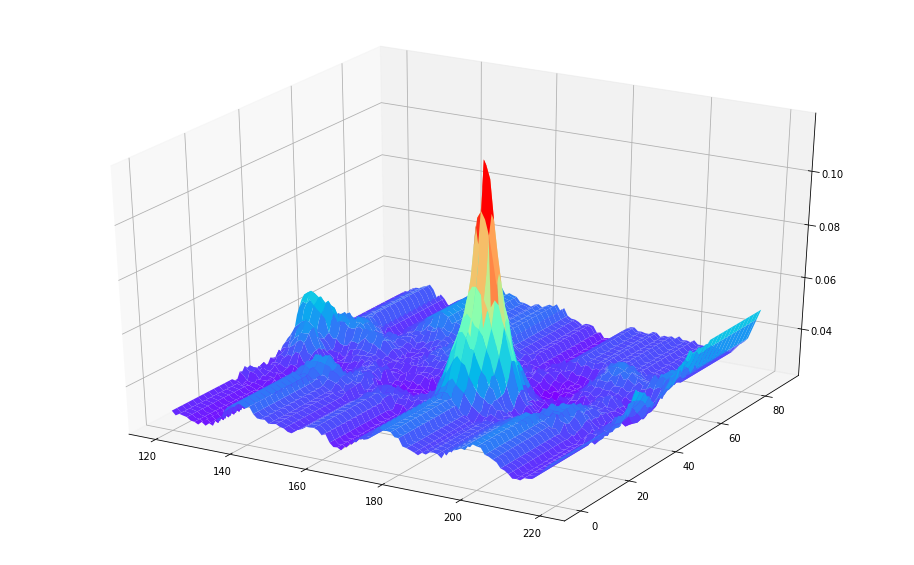

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 4))
X = np.arange(mi_arr_pad.shape[1])
Y = mi_arr_pad[max_mi_pos_pad[0],:,max_mi_pos_pad[2]]
ax[0].plot(X, Y)

X = np.arange(mi_arr_pad.shape[2])
Y = mi_arr_pad[max_mi_pos_pad[0],max_mi_pos_pad[1],:]
ax[1].plot(X, Y)

X = np.arange(120, 220)
Y = np.arange(0, mi_arr_pad.shape[2])
Y, X = np.meshgrid(Y, X)
Z = mi_arr_pad[max_mi_pos_pad[0],120:220]

fig = plt.figure(figsize=(16, 10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.rainbow, linewidth=0, antialiased=True)